In [1]:
#!pip install tensorflow pandas sklearn numpy

## Goals

 - Loading the frames generated by our `simulator.py`
     - TODO: Generate Realtime System Simulations with different behaviours (No, Medium or Strong Perturbations)
     - TODO: Label the frames correctly
 - Preprocess the frames
 - Select a first model for experimentation purposes (TensorFlow)
 - Train the model on the loaded frames
 - Analyze the model performance on newly generated frames
 - Adjust either the model or the simulator and repeat all the steps above.

In [2]:
import tensorflow as tf

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib

In [5]:
tf.__version__

'1.15.0'

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
train_dir = os.path.join(".", 'frames', 'train')
validation_dir = os.path.join(".", 'frames', 'valid')

In [8]:
train_stable_dir = os.path.join(train_dir, 'stable')
train_malfunction_dir = os.path.join(train_dir, 'malfunction')

validation_stable_dir = os.path.join(validation_dir, 'stable')
validation_malfunction_dir = os.path.join(validation_dir, 'malfunction')

In [9]:
train_stable_num = len(os.listdir(train_stable_dir))
train_malfunction_num = len(os.listdir(train_malfunction_dir))

validation_stable_num = len(os.listdir(validation_stable_dir))
validation_malfunction_num = len(os.listdir(validation_malfunction_dir))

total_train = train_stable_num + train_malfunction_num
total_validation = validation_stable_num + validation_malfunction_num

In [10]:
print('total training stable images:', train_stable_num)
print('total training malfunction images:', train_malfunction_num)
print('--')
print('total validation stable images:', validation_stable_num)
print('total validation malfunction images:', validation_malfunction_num)
print("----")
print("Total training images:", total_train)
print("Total validation images:", total_validation)

total training stable images: 1100
total training malfunction images: 1100
--
total validation stable images: 1100
total validation malfunction images: 1100
----
Total training images: 2200
Total validation images: 2200


In [11]:
batch_size = 10
epochs = 10
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [12]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [13]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')
validation_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=validation_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 2200 images belonging to 2 classes.
Found 2200 images belonging to 2 classes.


In [14]:
model = Sequential([
    Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(),
    Conv2D(32, (3,3), padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy', 'mse'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0

In [17]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=validation_data_gen,
    validation_steps=total_validation // batch_size
)

Epoch 1/10
220/220 [==============================] - 51s 232ms/step - loss: 0.5432 - acc: 0.7091 - mean_squared_error: 8.6019 - val_loss: 0.1775 - val_acc: 0.9600 - val_mean_squared_error: 16.3740
Epoch 2/10
220/220 [==============================] - 41s 187ms/step - loss: 0.2632 - acc: 0.9077 - mean_squared_error: 27.0610 - val_loss: 0.1737 - val_acc: 0.9259 - val_mean_squared_error: 33.1543
Epoch 3/10
220/220 [==============================] - 34s 154ms/step - loss: 0.2409 - acc: 0.9141 - mean_squared_error: 44.6224 - val_loss: 0.1371 - val_acc: 0.9705 - val_mean_squared_error: 56.3207
Epoch 4/10
220/220 [==============================] - 34s 155ms/step - loss: 0.2296 - acc: 0.9218 - mean_squared_error: 60.2824 - val_loss: 0.1043 - val_acc: 0.9736 - val_mean_squared_error: 131.4664
Epoch 5/10
220/220 [==============================] - 34s 153ms/step - loss: 0.2190 - acc: 0.9255 - mean_squared_error: 80.5241 - val_loss: 0.1446 - val_acc: 0.9473 - val_mean_squared_error: 104.8302
Epoc

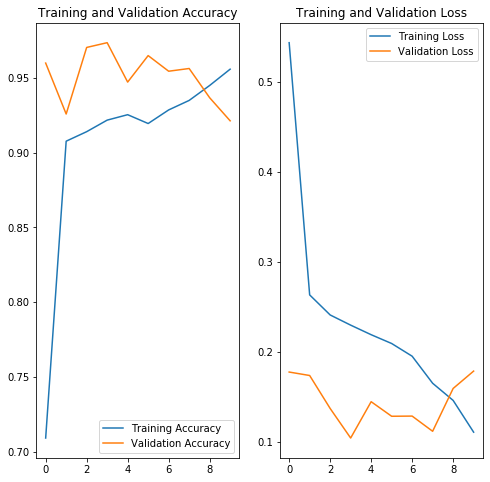

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
import pandas as pd

In [37]:
data = pd.DataFrame(history.history)
data.to_csv("naive_approach_data.csv", index=False)

In [38]:
data

,loss,acc,mean_squared_error,val_loss,val_acc,val_mean_squared_error
0,0.543182,0.709091,8.601890,0.177526,0.960000,16.373972
1,0.263181,0.907727,27.060970,0.173688,0.925909,33.154270
2,0.240909,0.914091,44.622421,0.137100,0.970455,56.320744
3,0.229614,0.921818,60.282364,0.104270,0.973636,131.466385
4,0.218985,0.925455,80.524063,0.144607,0.947273,104.830193
5,0.209221,0.919545,101.959824,0.128440,0.965000,110.841553
6,0.195115,0.928636,129.835205,0.128631,0.954545,144.646698
7,0.165081,0.935000,171.959290,0.111769,0.956364,432.354950
8,0.146045,0.945000,243.754379,0.159292,0.936818,224.078659
9,0.110779,0.955909,423.151550,0.178584,0.921364,417.421021


In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
data["type"] = "Training"

In [41]:
s = data.filter(["val_loss", "val_acc", "val_mean_squared_error"])
data.drop(["val_loss", "val_acc", "val_mean_squared_error"], axis=1, inplace=True)
s.columns = ["loss", "acc", "mean_squared_error"]
s["type"] = "Validation"
data = data.append(s)

In [42]:
data = data.reset_index(drop=True)
data

,loss,acc,mean_squared_error,type
0,0.543182,0.709091,8.601890,Training
1,0.263181,0.907727,27.060970,Training
2,0.240909,0.914091,44.622421,Training
3,0.229614,0.921818,60.282364,Training
4,0.218985,0.925455,80.524063,Training
5,0.209221,0.919545,101.959824,Training
6,0.195115,0.928636,129.835205,Training
7,0.165081,0.935000,171.959290,Training
8,0.146045,0.945000,243.754379,Training
9,0.110779,0.955909,423.151550,Training


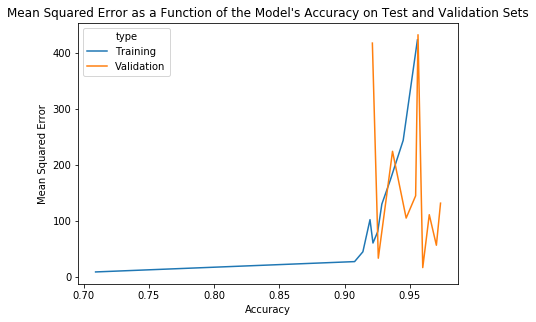

In [43]:
plt.figure(figsize=(6.8,4.8))
g = sns.lineplot(data=data, x="acc", y="mean_squared_error", hue="type")
g.set_title("Mean Squared Error as a Function of the Model's Accuracy on Training and Validation Sets")
g.set_xlabel("Accuracy")
g.set_ylabel("Mean Squared Error")
plt.show()

Text(0, 0.5, 'Loss')

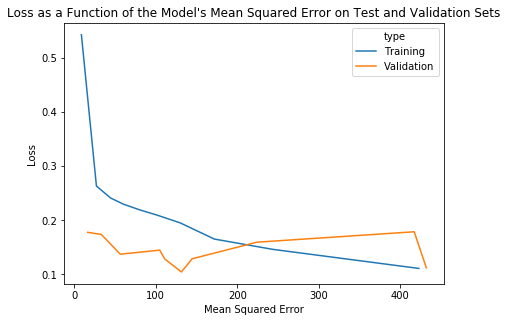

In [44]:
plt.figure(figsize=(6.8,4.8))
g = sns.lineplot(data=data, x="mean_squared_error", y="loss", hue="type")
g.set_title("Loss as a Function of the Model's Mean Squared Error on Training and Validation Sets")
g.set_xlabel("Mean Squared Error")
g.set_ylabel("Loss")